# Probabilistic forecasting: prediction intervals and prediction distribution

When trying to anticipate future values, most forecasting models focus on predicting the most likely value, which is called point-forecasting. Although knowing the expected value of a time series is useful for most business cases, this type of forecasting does not provide any information about the model's confidence or the prediction's uncertainty.


Probabilistic forecasting, as opposed to point-forecasting, is a family of techniques that enable the prediction of the expected distribution of the outcome, rather than a single future value. This type of forecasting provides much richer information, as it reports the range of probable values into which the true value may fall, allowing the estimation of prediction intervals.


A prediction interval is the interval within which the true value of the response variable is expected to be found with a given probability. There are [multiple ways to estimate prediction intervals](https://otexts.com/fpp3/prediction-intervals.html), most of which require that the residuals (errors) of the model follow a normal distribution. However, when this assumption cannot be made, two commonly used alternatives are bootstrapping and quantile regression.

To illustrate how skforecast enables the estimation of prediction intervals for multi-step forecasting, examples attempting to predict energy demand for a 7-day horizon are provided. Two strategies are showcased:

+ Prediction intervals based on bootstrapped residuals.

+ Prediction intervals based on quantile regression.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

As Rob J Hyndman explains in his <a href="https://robjhyndman.com/hyndsight/narrow-pi/">blog</a>, in real-world problems, almost all prediction intervals are too narrow. For example, nominal 95% intervals may only provide coverage between 71% and 87%. This is a well-known phenomenon and arises because they do not account for all sources of uncertainty. With forecasting models, there are at least four sources of uncertainty:

<ul>
  <li>The random error term</li>
    
  <li>The parameter estimates</li>
    
  <li>The choice of model for the historical data</li>
    
  <li>The continuation of the historical data generating process into the future</li>
</ul>

When producing prediction intervals for time series models, generally only the first of these sources is taken into account. Therefore, it is advisable to use test data to validate the empirical coverage of the interval and not solely rely on the expected coverage.

</div>

## Predicting distribution and intervals using bootstrapped residuals

The error of a one-step-ahead forecast is defined as the difference between the actual value and the predicted value ($e_t = y_t - \hat{y}_{t|t-1}$). By assuming that future errors will be similar to past errors, it is possible to simulate different predictions by taking samples from the collection of errors previously seen in the past (i.e., the residuals) and adding them to the predictions.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals.png" style="width: 700px;">
<br>
<font size="2.5"> <i>Diagram bootstrapping prediction process.</i></font>
</p>

Repeatedly performing this process creates a collection of slightly different predictions, which represent the distribution of possible outcomes due to the expected variance in the forecasting process.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals-2.png" style="width: 550px;">
<br>
<font size="2.5"> <i>Bootstrapping predictions.</i></font>
</p>

Using the outcome of the bootstrapping process, prediction intervals can be computed by calculating the $α/2$ and $1 − α/2$ percentiles at each forecasting horizon. 

<p style="text-align: center">
<img src="../img/forecasting-intervals.gif" style="width: 800px;">
</p>

Alternatively, it is also possible to fit a parametric distribution for each forecast horizon. 

One of the main advantages of this strategy is that it requires only a single model to estimate any interval. However, performing hundreds or thousands of bootstrapping iterations can be computationally expensive and may not always be feasible.

## Probabilistic prediction methods

In skforecast, all forecasters have three different methods that allow for probabilistic forecasting:

+ `predict_bootstrapping`: this method generates multiple forecasting predictions through a bootstrapping process. By sampling from a collection of past observed errors (the residuals), each bootstrapping iteration generates a different set of predictions. The output is a `pandas DataFrame` with one row for each predicted step and one column for each bootstrapping iteration.

+ `predict_intervals`: this method estimates quantile predictions intervals using the values generated with `predict_bootstrapping`.

+ `predict_quantiles`: this method estimates a list of quantile predictions using the values generated with `predict_bootstrapping`.

+ `predict_dist`: this method fits a parametric distribution using the values generated with `predict_bootstrapping`. Any of the continuous distributions available in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) can be used.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px;">
<p class="title">
    <i class="fa-solid fa-fire-flame-curved" style="font-size: 18px; color:#00bfa5;"></i>
    <b> &nbsp Tip</b>
</p>

The following example shows how to use these methods with a <code>ForecasterAutoreg</code>, but note that this works for all other types of Forecasters as well.

</div>

## Libraries

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.plot import plot_prediction_distribution
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_pinball_loss
from skforecast.exceptions import LongTrainingWarning

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Data

In [2]:
# Data download
# ==============================================================================
url = (
       'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
       'data/vic_elec.csv'
)
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='D', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})

data.head(3)

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True


In [3]:
# Split data into train-validation-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(
    f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}"
    f"  (n={len(data_train)})"
)
print(
    f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}"
    f"  (n={len(data_val)})"
)
print(
    f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}"
    f"  (n={len(data_test)})"
)

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


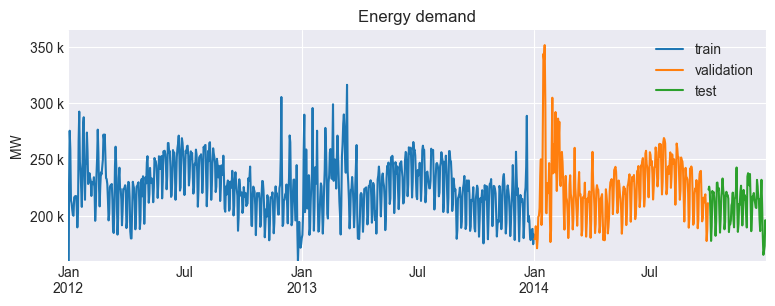

In [4]:
# Plot time series partition
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3))
data_train['Demand'].plot(label='train', ax=ax)
data_val['Demand'].plot(label='validation', ax=ax)
data_test['Demand'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylim(bottom=160_000)
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand')
ax.legend();

## Probabilistic forecasting

In [5]:
# Create and train a ForecasterAutoreg
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(
                                 learning_rate = 0.01,
                                 max_depth     = 10,
                                 n_estimators  = 500,
                                 random_state  = 123
                             ),
                 lags      = 7
             )

forecaster.fit(y=data.loc[end_train:end_validation, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=500,
              random_state=123) 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2014-09-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
C

### Predict Bootstraping

Once the Forecaster has been trained, the method `predict_bootstraping` can be use to simulate `n_boot` values of the forecasting distribution.

In [6]:
# Predict 10 different forecasting sequences of 7 steps each using bootstrapping
# ==============================================================================
boot_predictions = forecaster.predict_bootstrapping(steps=7, n_boot=10)
boot_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9
2014-10-01,208783.097577,204764.999003,201367.203420,212280.661192,204622.100582,202889.246579,210078.609982,210151.742392,200990.348257,203137.232359
2014-10-02,212340.130913,208320.030667,217221.147681,209996.152477,218464.949614,212545.697772,212061.596039,216579.376162,226902.326444,212847.017644
2014-10-03,221380.131363,223890.630246,224625.204840,207260.018970,206099.826214,288939.369743,220085.831843,229514.853352,230476.360893,224059.729506
2014-10-04,209943.773973,212946.528553,200027.296792,203592.696069,194120.730680,262225.653280,212516.896678,222042.271003,215236.033624,222487.580478
2014-10-05,193372.607408,177195.227257,194351.934752,206606.909536,202654.435499,297740.735825,192454.576530,199372.141645,208527.690318,197830.624380
2014-10-06,199626.367544,203338.054671,207145.334747,208993.695577,204766.177714,258050.416951,184903.916795,201473.420885,204790.425542,183312.907014
2014-10-07,201546.003371,212477.910879,209639.468951,204102.852012,225036.945159,257847.869040,197235.769115,196990.134684,200007.936217,207116.299541


Using a [ridge plot](https://www.data-to-viz.com/graph/ridgeline.html) is a useful way to visualize the uncertainty of a forecasting model. This plot estimates a kernel density for each step by using the bootstrapped predictions.

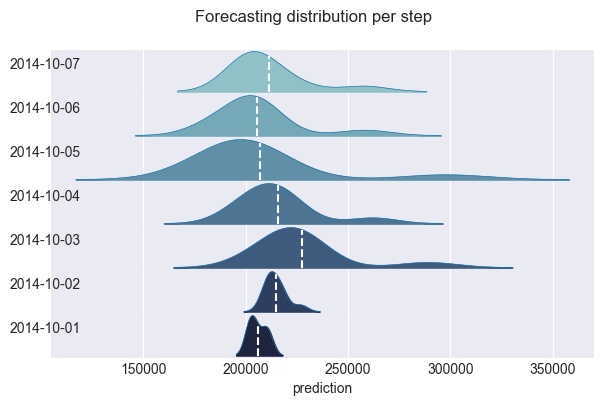

In [7]:
# Ridge plot of bootstrapping predictions
# ==============================================================================
_ = plot_prediction_distribution(boot_predictions, figsize=(7, 4))

### Predict Interval

In most cases, the user is interested in a specific interval rather than the entire bootstrapping simulation matrix. To address this need, skforecast provides the `predict_interval` method. This method internally uses `predict_bootstrapping` to obtain the bootstrapping matrix and estimates the upper and lower quantiles for each step, thus providing the user with the desired prediction intervals.

In [8]:
# Predict intervals for next 7 steps, quantiles 10th and 90th
# ==============================================================================
predictions = forecaster.predict_interval(steps=7, interval=[10, 90], n_boot=1000)
predictions

,pred,lower_bound,upper_bound
2014-10-01,205723.923923,195483.862851,214883.472075
2014-10-02,215167.163121,204160.738452,225623.750301
2014-10-03,225144.443075,212599.136391,237675.514362
2014-10-04,211406.440681,196863.841123,234950.293307
2014-10-05,194848.766987,185544.868289,225497.131653
2014-10-06,201901.819903,188334.486578,226720.998742
2014-10-07,208648.526025,191797.716429,231948.852094


### Predict Quantile

This method operates identically to `predict_interval`, with the added feature of enabling users to define a specific list of quantiles for estimation at each step. It's important to remember that these quantiles should be specified within the **range of 0 to 1**.

In [9]:
# Predict quantiles for next 7 steps, quantiles 5th, 25th, 75th and 95th
# ==============================================================================
predictions = forecaster.predict_quantiles(steps=7, quantiles=[0.05, 0.25, 0.75, 0.95], n_boot=1000)
predictions

,q_0.05,q_0.25,q_0.75,q_0.95
2014-10-01,190931.232112,201367.203420,209262.858754,217730.216823
2014-10-02,200073.450004,209983.877484,219323.939792,240417.202430
2014-10-03,208422.554331,218572.814092,230091.464603,251383.795523
2014-10-04,192618.644753,204251.785931,222408.098868,256285.360096
2014-10-05,181143.759693,191499.233675,207377.126997,255789.774545
2014-10-06,184887.453266,194613.761232,208546.550156,257237.948263
2014-10-07,187384.716314,198277.712914,212038.622323,256921.642212


### Predict Distribution

The intervals estimated so far are distribution-free, which means that no assumptions are made about a particular distribution. The `predict_dist` method in skforecast allows fitting a parametric distribution to the bootstrapped prediction samples obtained with `predict_bootstrapping`. This is useful when there is reason to believe that the forecast errors follow a particular distribution, such as the normal distribution or the student's t-distribution. The `predict_dist` method allows the user to specify any continuous distribution from the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) module.

In [10]:
# Predict the parameters of a normal distribution for the next 7 steps
# ==============================================================================
from scipy.stats import norm

predictions = forecaster.predict_dist(steps=7, distribution=norm, n_boot=1000)
predictions

,loc,scale
2014-10-01,205374.632063,12290.061732
2014-10-02,215791.488070,13607.935838
2014-10-03,225631.039103,14206.970100
2014-10-04,215210.987777,18980.776421
2014-10-05,202613.715687,19980.302998
2014-10-06,205391.493409,19779.732794
2014-10-07,208579.269999,18950.289467


## Backtesting with prediction intervals

A backtesting process can be applied to evaluate the performance of the forecaster over a period of time, for example on test data, and calculate the actual coverage of the estimated range.

In [11]:
# Backtesting on test data 
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['Demand'],
                          steps                 = 7,
                          metric                = 'mean_squared_error',
                          initial_train_size    = len(data_train) + len(data_val),
                          fixed_train_size      = True,
                          gap                   = 0,
                          allow_incomplete_fold = True,
                          refit                 = True,
                          interval              = [10, 90],
                          n_boot                = 1000,
                          random_state          = 123,
                          verbose               = False,
                          show_progress         = True
                      )
predictions.head(4)

  0%|          | 0/13 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2014-10-01,223264.432587,214633.692784,231376.785240
2014-10-02,233596.210854,223051.862727,244752.538248
2014-10-03,242653.671597,226947.654906,258361.695192
2014-10-04,220842.603128,209967.438912,236404.408845


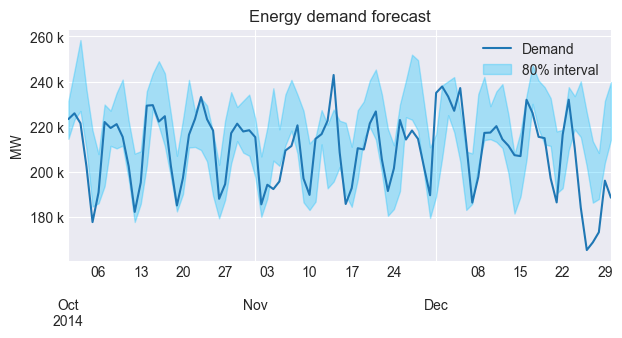

In [12]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '80% interval'
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand forecast')
ax.legend();

In [13]:
# Interval coverage on test data
# ==============================================================================
inside_interval = np.where(
                      (data.loc[predictions.index, 'Demand'] >= predictions['lower_bound']) & \
                      (data.loc[predictions.index, 'Demand'] <= predictions['upper_bound']),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}")

Coverage of the predicted interval on test data: 65.93406593406593


The coverage of the predicted interval is much lower than expected (80%).

## Prediction with out-sample residuals

By default, the training residuals are used to create the prediction intervals. However, this is not the most recommended option as the estimated interval tends to be too narrow. This is because the model's performance on training data is usually better than on new observations, leading to smaller residuals and, in turn, narrower prediction intervals.

To overcome this issue, it is advisable to use other residuals, such as those obtained from a validation set. This can be achieved by storing the new residuals inside the forecaster using the `set_out_sample_residuals` method.

In [14]:
# Backtesting using validation data
# ==============================================================================
metric, backtest_predictions = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.loc[:end_validation, 'Demand'],
                                   initial_train_size = len(data_train),
                                   steps              = 7,
                                   refit              = True,
                                   metric             = 'mean_squared_error',
                                   verbose            = False,
                                   show_progress      = True
                               )

# Calculate residuals in validation data
# ==============================================================================
residuals = (data_val['Demand'] - backtest_predictions['pred']).to_numpy()
residuals[:5]

  0%|          | 0/39 [00:00<?, ?it/s]

array([-16084.02669559, -14168.47600418,  -4416.31618072, -15101.78356121,
       -31133.70782794])

Once the residuals of the validation set are calculated, they can be stored inside the forecaster. This allows the forecaster to use the out-of-sample residuals for prediction interval calculation instead of the default in-sample residuals. By doing so, the estimated prediction intervals will be less optimistic and more representative of the performance of the model on new observations.

In [15]:
# Set out-sample residuals
# ==============================================================================
forecaster.set_out_sample_residuals(residuals=residuals)

Once the new residuals have been added to the forecaster, use `in_sample_residuals = False` when calling the prediction methods.

In [16]:
# Predict intervals using out-sample residuals
# ==============================================================================
forecaster.predict_interval(
    steps               = 7, 
    interval            = [10, 90], 
    n_boot              = 1000,
    in_sample_residuals = False
)

,pred,lower_bound,upper_bound
2014-10-01,205723.923923,186442.948366,219301.240056
2014-10-02,215167.163121,193309.527919,237664.343916
2014-10-03,225144.443075,202621.185338,248592.853063
2014-10-04,211406.440681,190686.942976,252492.488196
2014-10-05,194848.766987,182470.870866,246304.519999
2014-10-06,201901.819903,183721.031607,243358.781198
2014-10-07,208648.526025,183541.873516,244359.947649


Also, a backtesting process can be applied to the test data with `in_sample_residuals = False` to use the out-of-sample residuals in the interval estimation.

In [17]:
# Backtesting using test data and out-sample residuals
# ==============================================================================
metric, predictions_2 = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = data['Demand'],
                            initial_train_size  = len(data_train) + len(data_val),
                            steps               = 7,
                            refit               = True,
                            interval            = [10, 90],
                            n_boot              = 1000,
                            in_sample_residuals = False,
                            random_state        = 123,
                            metric              = 'mean_squared_error',
                            verbose             = False,
                            show_progress       = True
                        )

predictions_2.head(4)

  0%|          | 0/13 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2014-10-01,223264.432587,203983.457029,236841.748720
2014-10-02,233596.210854,207273.919217,255429.172682
2014-10-03,242653.671597,211668.258043,265757.229322
2014-10-04,220842.603128,195869.206779,245921.530106


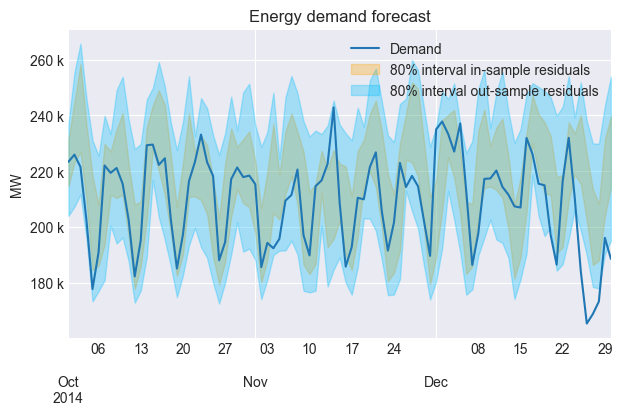

In [18]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'orange',
    alpha = 0.3,
    label = '80% interval in-sample residuals'
)
ax.fill_between(
    predictions_2.index,
    predictions_2['lower_bound'],
    predictions_2['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '80% interval out-sample residuals'
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand forecast')
ax.legend(fontsize=10);

In [19]:
# Interval coverage on test data
# ==============================================================================
inside_interval = np.where(
                      (data.loc[predictions_2.index, 'Demand'] >= predictions_2['lower_bound']) & \
                      (data.loc[predictions_2.index, 'Demand'] <= predictions_2['upper_bound']),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval on test data: {100 * coverage}")

Coverage of the predicted interval on test data: 92.3076923076923


Using out-of-sample residuals, the interval coverage is much closer to that expected than when using in-sample residuals.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

In the case of <code>ForecasterAutoregDirect</code>, <code>ForecasterAutoregMultiSeries</code>, <code>ForecasterAutoregMultiSeriesCustom</code> and <code>ForecasterAutoregMultiVariate</code>, the residuals must be provided using a dictionary to indicate to which step or level (series) they belong to.
</div>

## Prediction intervals using quantile regression models


As opposed to linear regression, which is intended to estimate the conditional mean of the response variable given certain values of the predictor variables, quantile regression aims at estimating the conditional quantiles of the response variable. For a continuous distribution function, the $\alpha$-quantile $Q_{\alpha}(x)$ is defined such that the probability of $Y$ being smaller than $Q_{\alpha}(x)$ is, for a given $X=x$, equal to $\alpha$. For example, 36% of the population values are lower than the quantile  $Q=0.36$. The most known quantile is the 50%-quantile, more commonly called the median.

By combining the predictions of two quantile regressors, it is possible to build an interval. Each model estimates one of the limits of the interval. For example, the models obtained for $Q = 0.1$ and $Q = 0.9$ produce an 80% prediction interval (90% - 10% = 80%).

Several machine learning algorithms are capable of modeling quantiles. Some of them are:

+ [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

+ [XGBoost](https://xgboost.readthedocs.io/en/stable/python/index.html)

+ [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

+ [sklearn GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

+ [sklearn QuantileRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor)

+ [skranger quantile RandomForest](https://skranger.readthedocs.io/en/stable/index.html)


Just as the squared-error loss function is used to train models that predict the mean value, a specific loss function is needed in order to train models that predict quantiles. The most common metric used for quantile regression is calles [quantile loss  or pinball loss](https://en.wikipedia.org/wiki/Quantile_regression):


$$\text{pinball}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1}  \alpha \max(y_i - \hat{y}_i, 0) + (1 - \alpha) \max(\hat{y}_i - y_i, 0)$$

where $\alpha$ is the target quantile, $y$ the real value and $\hat{y}$ the quantile prediction.

It can be seen that loss differs depending on the evaluated quantile. The higher the quantile, the more the loss function penalizes underestimates, and the less it penalizes overestimates. As with MSE and MAE, the goal is to minimize its values (the lower loss, the better).

Two disadvantages of quantile regression, compared to the bootstrap approach to prediction intervals, are that each quantile needs its regressor and quantile regression is not available for all types of regression models. However, once the models are trained, the inference is much faster since no iterative process is needed.

This type of prediction intervals can be easily estimated using [ForecasterAutoregDirect](https://joaquinamatrodrigo.github.io/skforecast/latest/api/ForecasterAutoregDirect.html) and [ForecasterAutoregMultiVariate](https://joaquinamatrodrigo.github.io/skforecast/latest/api/ForecasterMultiVariate.html) models.

### Forecasters

As in the previous example, an 80% prediction interval is estimated for 7 steps-ahead predictions but, this time, using quantile regression. In this example a LightGBM gradient boosting model is trained, however, the reader can use any other model by simply substituting the regressor definition.

In [20]:
# Create forecasters: one for each bound of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).

# Forecaster for quantile 10%
forecaster_q10 = ForecasterAutoregDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.1,
                                     learning_rate = 0.1,
                                     max_depth     = 10,
                                     n_estimators  = 100
                                 ),
                     lags = 7,
                     steps = 7
                 )
                  
# Forecaster for quantile 90%
forecaster_q90 = ForecasterAutoregDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.9,
                                     learning_rate = 0.1,
                                     max_depth     = 10,
                                     n_estimators  = 100
                                 ),
                     lags = 7,
                     steps = 7
                 )

forecaster_q10.fit(y=data['Demand'])
forecaster_q90.fit(y=data['Demand'])

### Predictions

Once the quantile forecasters are trained, they can be used to predict each of the bounds of the forecasting interval.

In [21]:
# Predict intervals for next 7 steps
# ==============================================================================
predictions_q10 = forecaster_q10.predict(steps=7)
predictions_q90 = forecaster_q90.predict(steps=7)
predictions = pd.DataFrame({
                  'lower_bound': predictions_q10,
                  'upper_bound': predictions_q90,
              })
predictions 

,lower_bound,upper_bound
2014-12-31,177607.329878,218885.714906
2015-01-01,178062.602517,242582.788349
2015-01-02,186213.019530,220677.491829
2015-01-03,184901.085939,204261.638256
2015-01-04,193237.899189,235310.200573
2015-01-05,196673.050873,284881.068713
2015-01-06,184148.733152,293018.478848


When validating a quantile regression model, a custom metric must be provided depending on the quantile being estimated. These metrics will be used again when tuning the hyper-parameters of each model.

In [22]:
# Loss function for each quantile (pinball_loss)
# ==============================================================================
def mean_pinball_loss_q10(y_true, y_pred):
    """
    Pinball loss for quantile 10.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.1)


def mean_pinball_loss_q90(y_true, y_pred):
    """
    Pinball loss for quantile 90.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.9)

### Backtesting

In [23]:
# Backtesting on test data
# ==============================================================================
warnings.simplefilter('ignore', category=LongTrainingWarning)
metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster         = forecaster_q10,
                                  y                  = data['Demand'],
                                  initial_train_size = len(data_train) + len(data_val),
                                  steps              = 7,
                                  refit              = True,
                                  metric             = mean_pinball_loss_q10,
                                  verbose            = False,
                                  show_progress      = False
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster         = forecaster_q90,
                                  y                  = data['Demand'],
                                  initial_train_size = len(data_train) + len(data_val),
                                  steps              = 7,
                                  refit              = True,
                                  metric             = mean_pinball_loss_q90,
                                  verbose            = False,
                                  show_progress      = False
                              )

print("Quantile 10 metric", metric_q10)
print("Quantile 90 metric", metric_q90)
print("")
display(predictions_q10.head(4))
print("")
display(predictions_q90.head(4))

Quantile 10 metric 3408.28324086281
Quantile 90 metric 2616.1339689106367



,pred
2014-10-01,209699.327721
2014-10-02,218271.081905
2014-10-03,221150.120318
2014-10-04,208837.320910


,pred
2014-10-01,248739.650047
2014-10-02,241249.713258
2014-10-03,270670.830049
2014-10-04,220208.757206


Predictions generated for each model are used to define the upper and lower limits of the interval.

In [24]:
# Interval coverage on test data
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions_q10['pred']) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions_q90['pred']),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval: {100 * coverage}")

Coverage of the predicted interval: 61.53846153846154


The coverage of the predicted interval is much lower than expected (80%).

### Grid Search

The hyperparameters of the model were hand-tuned and there is no reason that the same hyperparameters are suitable for the 10th and 90th percentiles regressors. Therefore, a grid search is carried out for each forecaster.

In [25]:
# Grid search of hyper-parameters and lags for each quantile forecaster
# ==============================================================================
# Regressor hyper-parameters
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
lags_grid = [7]

results_grid_q10 = grid_search_forecaster(
                       forecaster         = forecaster_q10,
                       y                  = data.loc[:end_validation, 'Demand'],
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = 7,
                       refit              = False,
                       metric             = mean_pinball_loss_q10,
                       initial_train_size = int(len(data_train)),
                       return_best        = True,
                       verbose            = False,
                       show_progress      = True
                   )

results_grid_q90 = grid_search_forecaster(
                       forecaster         = forecaster_q90,
                       y                  = data.loc[:end_validation, 'Demand'],
                       param_grid         = param_grid,
                       lags_grid          = lags_grid,
                       steps              = 7,
                       refit              = False,
                       metric             = mean_pinball_loss_q90,
                       initial_train_size = int(len(data_train)),
                       return_best        = True,
                       verbose            = False,
                       show_progress      = True
                   )

Number of models compared: 12.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 2713.0192469016706

Number of models compared: 12.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 4094.3047516967745



In [26]:
# Grid search results
# ==============================================================================
display(results_grid_q10.head(4))
print("")
display(results_grid_q90.head(4))

,lags,params,mean_pinball_loss_q10,learning_rate,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",2713.019247,0.01,3.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",2724.174361,0.01,5.0,500.0
5,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",2794.381391,0.01,10.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",2831.048035,0.10,3.0,100.0


,lags,params,mean_pinball_loss_q90,learning_rate,max_depth,n_estimators
5,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",4094.304752,0.01,10.0,500.0
10,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",4185.354890,0.10,10.0,100.0
3,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",4198.557508,0.01,5.0,500.0
8,"[1, 2, 3, 4, 5, 6, 7]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",4202.854953,0.10,5.0,100.0


### Backtesting using test data

Once the best hyperparameters have been found for each forecaster, a [backtesting process](https://skforecast.org/latest/user_guides/backtesting.html) is applied again using the test data.

In [27]:
# Backtesting on test data
# ==============================================================================
metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster         = forecaster_q10,
                                  y                  = data['Demand'],
                                  initial_train_size = len(data_train) + len(data_val),
                                  steps              = 7,
                                  refit              = False,
                                  metric             = mean_pinball_loss_q10,
                                  verbose            = False
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster         = forecaster_q90,
                                  y                  = data['Demand'],
                                  initial_train_size = len(data_train) + len(data_val),
                                  steps              = 7,
                                  refit              = False,
                                  metric             = mean_pinball_loss_q90,
                                  verbose            = False
                              )

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

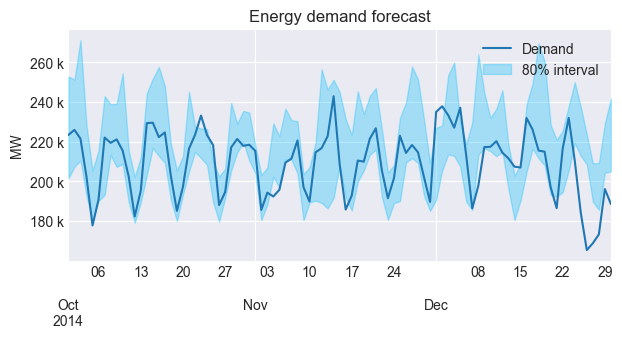

In [28]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Demand')
ax.fill_between(
    data.loc[end_validation:].index,
    predictions_q10['pred'],
    predictions_q90['pred'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '80% interval'
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand forecast')
ax.legend();

In [29]:
# Interval coverage
# ==============================================================================
inside_interval = np.where(
                      (data.loc[end_validation:, 'Demand'] >= predictions_q10['pred']) & \
                      (data.loc[end_validation:, 'Demand'] <= predictions_q90['pred']),
                      True,
                      False
                  )

coverage = inside_interval.mean()
print(f"Coverage of the predicted interval: {100 * coverage}")

Coverage of the predicted interval: 75.82417582417582


After optimizing the hyper-parameters of each quantile forecaster, the coverage is closer to the expected one (80%).